In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import numpy as np

In [2]:
import os
from os.path import expanduser
home = expanduser("~")
os.chdir(os.path.join(home, 'Documents', 'Trainings', 'inpost'))
print('Current working directory set to:')
os.getcwd()

Current working directory set to:


'/Users/joannawojdylo/Documents/Trainings/inpost'

In [3]:
RAW_DIR = os.path.join(os.getcwd(), 'data', 'raw')
csv_name = "simulated_ts.csv"

Load the data into pandas Dataframe

In [4]:
data = pd.read_csv(os.path.join(RAW_DIR, csv_name), delimiter=";")

In [5]:
data.head()

,time id,y
0,1,"105,9289584"
1,2,"22,37581446"
2,3,"230,0636468"
3,4,"111,7133611"
4,5,"8,710064031"


Check data types

In [6]:
data.dtypes

time id     int64
y          object
dtype: object

Looks like we have strings in "y" column, because of the decimal notation used. Let's switch to '.' instead of ',' and cast the "y" column to float values.

In [7]:
data['y'] = data['y'].str.replace(',', '.')
data['y'] = pd.to_numeric(data['y'])
data.dtypes

time id      int64
y          float64
dtype: object

Check for any missing values

In [8]:
data.isnull().sum() 

time id    0
y          0
dtype: int64

Set time id column as a DataFrame index for clarity

In [9]:
data.set_index("time id", inplace=True)

Take a look on basic statistic for better data understanding

In [10]:
data['y'].describe().round(2)

count     499.00
mean     1298.38
std       719.09
min       -51.58
25%       765.83
50%      1249.26
75%      1743.66
max      3397.00
Name: y, dtype: float64

Visualization of the data and its moving average series (window = 14)

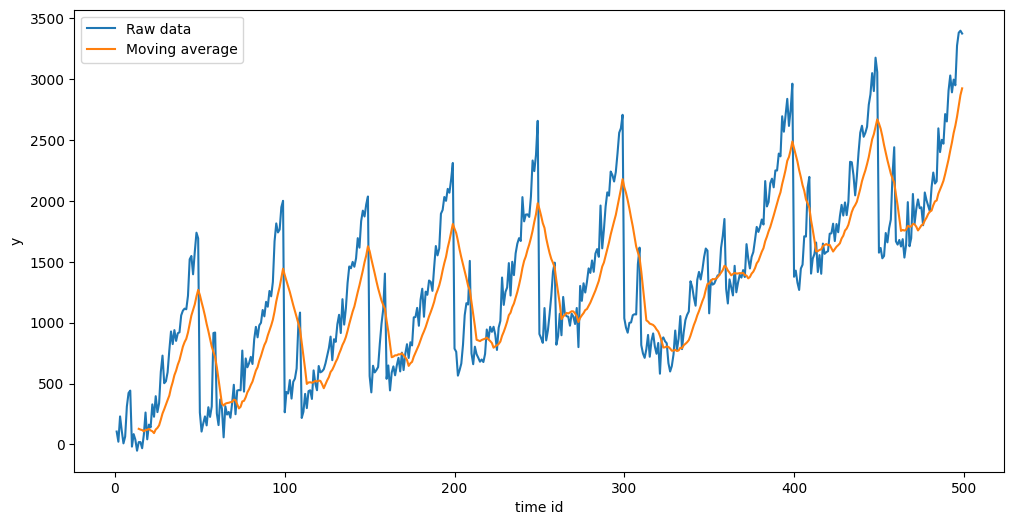

In [11]:
mavg = data['y'].rolling(window=14).mean()
plt.figure(figsize = (12,6))
data['y'].plot(label='Raw data')
mavg.plot(label='Moving average')
# plt.xlabel('Time')
plt.ylabel('y')
plt.legend()

In [12]:
train_test_split_value = 489
data_train=data[:train_test_split_value]
data_test=data[train_test_split_value:]

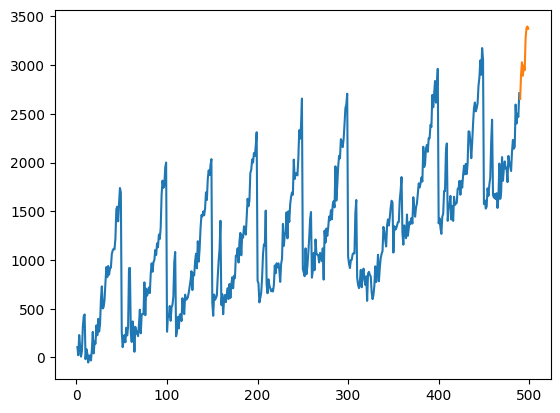

In [13]:
plt.plot(data_train)
plt.plot(data_test)

### Stationarity tests ###

In [14]:
from arch.unitroot import ADF, KPSS, PhillipsPerron

In [15]:
adf = ADF(data_train, lags=50)
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -0.296
P-value                         0.926
Lags                               50
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


P-value 0.926 greater than 0.05 significance level -> we do not reject null hypothesis -> process is not stationary

In [16]:
kpss = KPSS(data_train, lags=50)
print(kpss.summary().as_text())

    KPSS Stationarity Test Results   
Test Statistic                  0.973
P-value                         0.003
Lags                               50
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


P-value 0.003 lower than 0.05 significance level -> we do reject null hypothesis -> process is not stationary

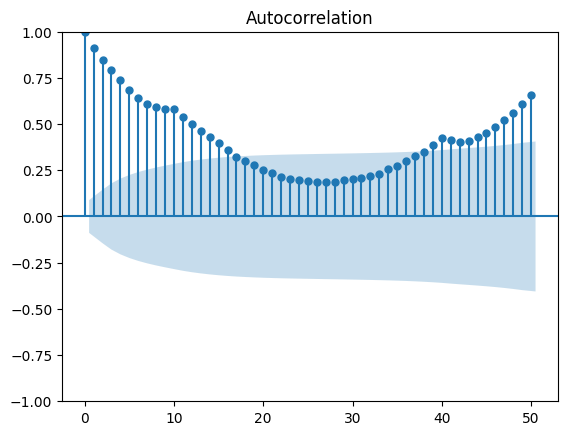

In [17]:
plot_acf(data_train, lags=50)
plt.show()

### Let's see the results of 1st order differencing ###

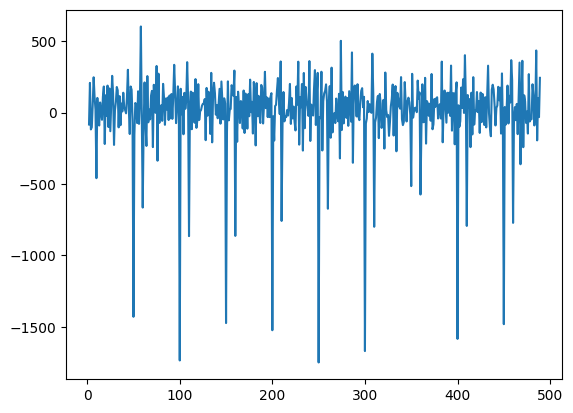

In [18]:
plt.plot(data_train.diff())

In [19]:
adf = ADF(data_train.diff().dropna(), lags=50)
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -3.661
P-value                         0.005
Lags                               50
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [20]:
kpss = KPSS(data_train.diff().dropna(), lags=50)
print(kpss.summary().as_text())

    KPSS Stationarity Test Results   
Test Statistic                  0.140
P-value                         0.422
Lags                               50
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


In [21]:
pp = PhillipsPerron(data_train.diff().dropna(), lags=50)
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -52.664
P-value                         0.000
Lags                               50
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


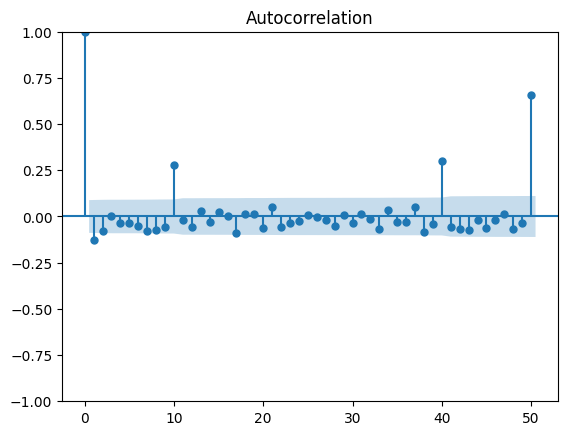

In [22]:
plot_acf(data_train.diff().dropna(), lags=50)
plt.show()

We may observe single points outside the confidence interval, but these are isolated cases that we can ignore. ACF indicating MA process with 1 lag.

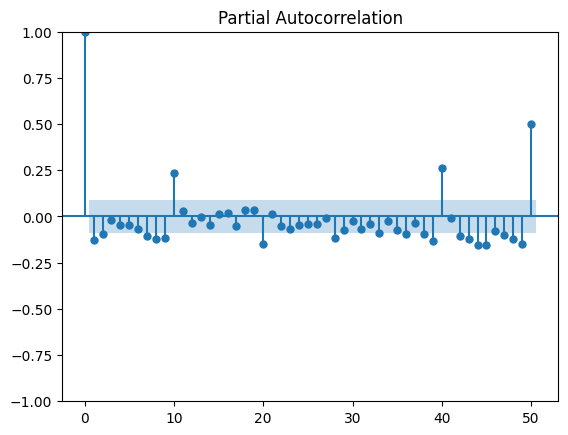

In [23]:
plot_pacf(data_train.diff().dropna(), lags=50, method='ywm')
plt.show()

The PACF chart looks decidedly worse: there are many observations outside the confidence interval, suggesting seasonal/trend remains in the data. We can also see this in the chart of the differentiated data itself, where the weight of the data is definitely on the negative values. So let's try to differentiate our data once again.

### The 2nd order differencing ###

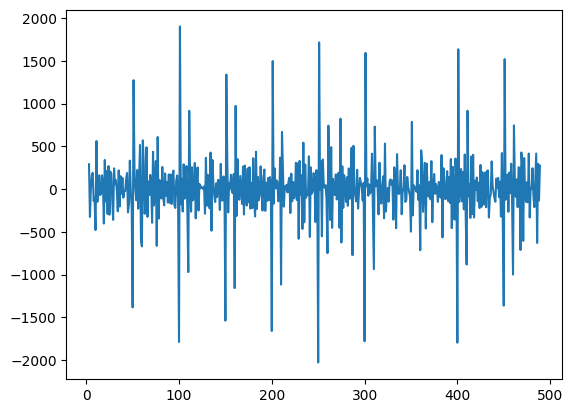

In [24]:
plt.plot(data_train.diff().diff())

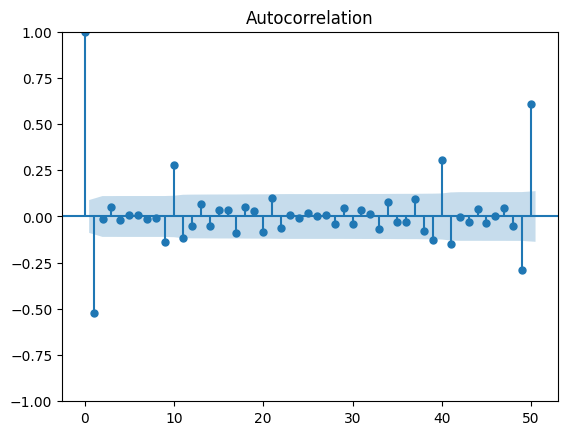

In [25]:
plot_acf(data_train.diff().diff().dropna(), lags=50)
plt.show()

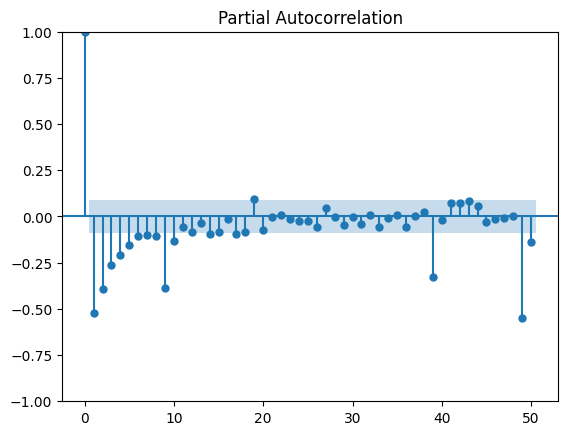

In [26]:
plot_pacf(data_train.diff().diff().dropna(), lags=50, method='ywm')
plt.show()

## Let's harness the information criteria and auto arima function ##

In [27]:
arima_model =  auto_arima(data_train,start_p=0, start_q=0, d=2, # we specify d=2 as we used 2nd order differencing
                          max_p=5, max_d=5, max_q=5, start_P=0,
                          start_Q=0, max_P=5, max_D=5,
                          max_Q=5, seasonal=True, 
                          error_action='warn',trace = True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=7246.788, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=7093.101, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=7013.132, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=6979.721, Time=0.02 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=6960.339, Time=0.03 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=6950.216, Time=0.04 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=6952.214, Time=0.07 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 0.756 seconds


In [28]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  489
Model:               SARIMAX(5, 2, 0)   Log Likelihood               -3469.108
Date:                Fri, 07 Oct 2022   AIC                           6950.216
Time:                        19:33:37   BIC                           6975.345
Sample:                             0   HQIC                          6960.088
                                - 489                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9212      0.073    -12.625      0.000      -1.064      -0.778
ar.L2         -0.7771      0.080     -9.725      0.000      -0.934      -0.620
ar.L3         -0.5486      0.074     -7.384      0.000      -0.694      -0.403
ar.L4         -0.3465      0.060     -5.785      0.000      -0.464      -0.229
ar.L5         -0.1568      0.042     -3.689      0.000      -0.240      -0.073
sigma2      9.056e+04   2126.797     42.583      0.000    8.64e+04    9.47e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):              5132.23
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -3.09
Prob(H) (two-sided):                  0.11   Kurtosis:                        17.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

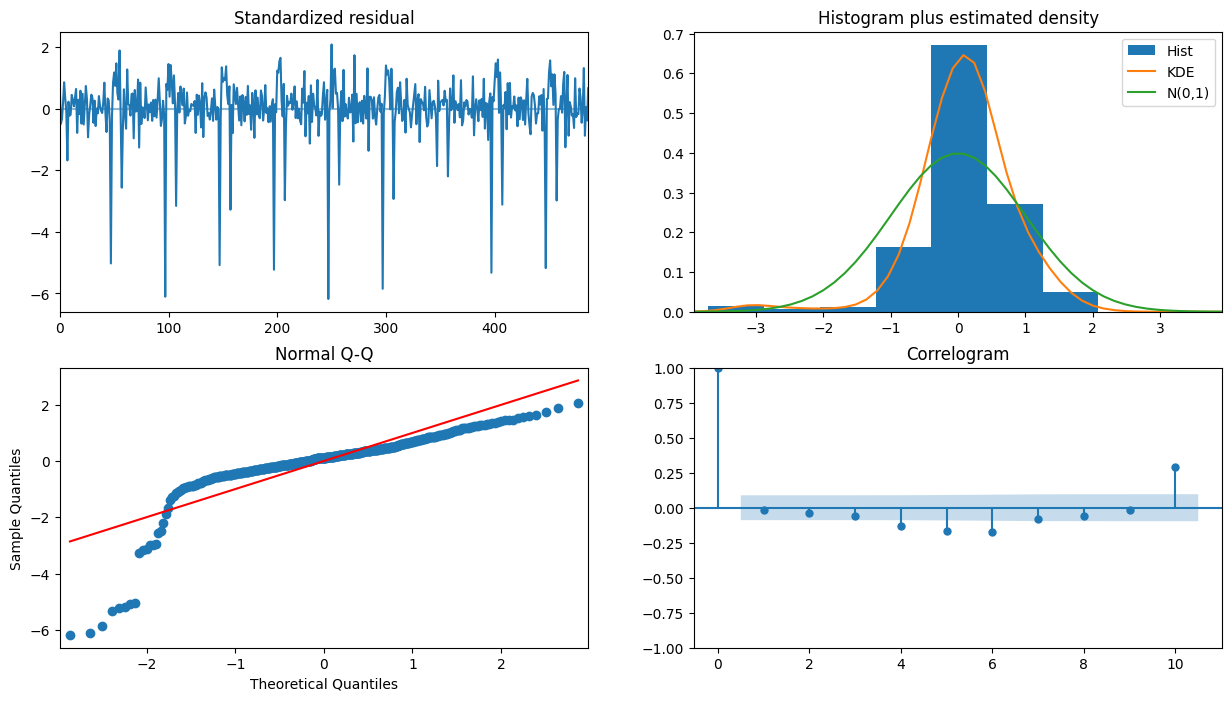

In [29]:
arima_model.plot_diagnostics(figsize=(15,8))
plt.show()

In [30]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 100),index=data_test.index)
prediction.columns = ['predicted_y']
prediction

/Users/joannawojdylo/opt/anaconda3/envs/inpost/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,predicted_y
time id,
490,2881.947728
491,2938.420048
492,3033.235261
493,3126.484197
494,3231.725711
495,3315.927920
496,3402.380902
497,3491.062585
498,3583.575353


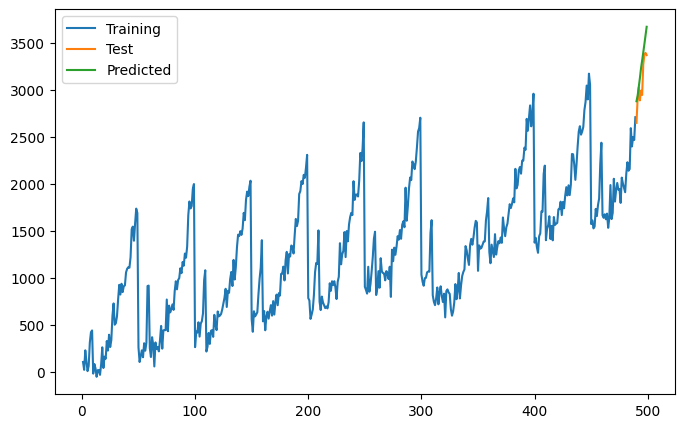

In [31]:
plt.figure(figsize=(8,5))
plt.plot(data_train,label="Training")
plt.plot(data_test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'upper left')
plt.show()

In [32]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
mae = mean_absolute_error(data_test, prediction)
mape = mean_absolute_percentage_error(data_test, prediction)
rmse = np.sqrt(mean_squared_error(data_test, prediction))
r2 = r2_score(data_test, prediction)
print(f'mae: {mae}')
print(f'mape: {mape}')
print(f'rmse: {rmse}')
print(f'r2: {r2}')

mae: 183.0719562155094
mape: 0.059971345006621005
rmse: 212.97725763055303
r2: 0.2325514360839912
